## Run SimSS simulations and plot the results
Version 0.0.1
(c) Vincent M. Le Corre (https://github.com/VMLC-PV)

In [3]:
# Package import
# %matplotlib inline
import os,platform,warnings,itertools,matplotlib,copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# Import homemade package by VLC
from SIMsalabim_utils.RunSim import *
from SIMsalabim_utils.SimSS_plots import *
from SIMsalabim_utils.aux_func import *
from SIMsalabim_utils.plot_settings_screen import *

## General Inputs
warnings.filterwarnings("ignore")           # Don't show warnings
system = platform.system()                  # Operating system
max_jobs = os.cpu_count()-2                 # Max number of parallel simulations (for number of CPU use: os.cpu_count() )
do_multiprocessing = False                      # Use multiprocessing
if system == 'Windows':                     # cannot easily do multiprocessing in Windows
        max_jobs = 1
        do_multiprocessing = False
        try:                                # kill all running jobs to avoid conflicts
            os.system('taskkill.exe /F /IM simss.exe')
        except:
            pass
matplotlib.rcParams['figure.figsize'] = (7, 5) # set default figure size

# Path to SIMsalabim
path2simu = os.path.join(os.getcwd() , 'Simulation_program','SIMsalabimv456','SimSS')

In [4]:
# Prepare the command strings to run
#First, we need to create a list of the filenames containing the experimental data
Gfracs = [0.015018854924793781, 0.037216477438136795, 0.059679767103348054, 0.08248423095584644, 0.09461426491994179, 0.14847161572052375, 0.19213973799126624, 0.22028141678796673, 0.32945172246482257, 0.44541484716157076, 0.5570111596312449, 0.6710334788937388, 0.7874818049490526, 0.8990781174187268, 1.0]
# Gfracs = [0.037216477438136795,0.19213973799126624,  0.32945172246482257,  0.5570111596312449, 0.6710334788937388,  0.8990781174187268, 1.0]

ExpDataNames = [] 
for i in Gfracs:
    ExpDataNames.append(os.path.join(path2simu,'Best','Ternary_best_device_{:.2e}_sun_full.txt'.format(i)))
#Then, we need to create a list with the strings to run the simulations (results from your fits)
fix_str =' device_parameters_OPV.txt'
str_lst = []
labels = []
for i in Gfracs:
    str_lst.append(fix_str+' -Gfrac {:.2e}'.format(i))
    labels.append('Gfrac {:.2e}'.format(i)) # Prepare custom labels


# Prepare necessary lists for the RunSimulation function
JV_files,Var_files,scPars_files,code_name_lst,path_lst = [],[],[],[],[]
for i in range(len(str_lst)):
    JV = 'JV_' + str(i) + '.dat'
    Var = 'Var_' + str(i) + '.dat'
    scPar = 'scPar_' + str(i) + '.dat'
    str_lst[i] = str_lst[i] + ' -JV_file ' + JV + ' -Var_file ' + Var + ' -scPars_file ' + scPar
    JV_files.append(os.path.join(path2simu,JV))
    Var_files.append(os.path.join(path2simu,Var))
    scPars_files.append(os.path.join(path2simu,scPar))
    code_name_lst.append('SimSS')
    path_lst.append(path2simu)


Simulation_Inputs = str_lst,JV_files,Var_files,scPars_files,code_name_lst,path_lst,labels

# Run the simulations
run_simu = True
if run_simu:
    RunSimulation(Simulation_Inputs,max_jobs=max_jobs,do_multiprocessing=do_multiprocessing,verbose=False) # runs the simulations


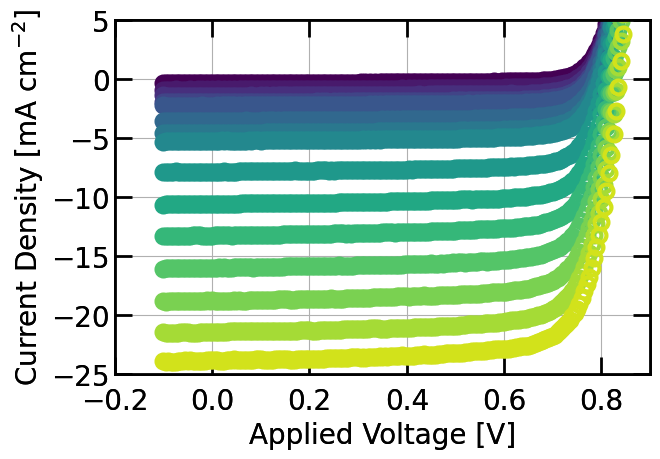

In [5]:
# Make JV plots
from SIMsalabim_utils.SimSS_plots import *
from SIMsalabim_utils.plot_settings_screen import *

# Plot the JV curves
colors = plt.cm.viridis(np.linspace(0,1,max(len(str_lst),3)+1)) # prepare color for plots

# plot lin-log JV
f = plt.figure(1)
PlotJV(JV_files, labels=labels,colors=colors,num_fig=1,plot_type=0,x='Vext',y=['Jext'],legend=False,xlimits=[-0.2,0.9],ylimits=[-25,5],absx=False,absy=False,x_unit='V',y_unit='mA/cm^2',save_fig=False,fig_name=os.path.join(path2simu,'JV.png'),mark='',line_type = ['-'])
PlotJV(ExpDataNames, labels=labels,colors=colors,num_fig=1,plot_type=0,x='V',y=['J'],legend=False,xlimits=[-0.2,0.9],ylimits=[-25,5],absx=False,absy=False,x_unit='V',y_unit='mA/cm^2',save_fig=True,fig_name=os.path.join('JV_OPV.png'),mark='o',line_type = ['None'])


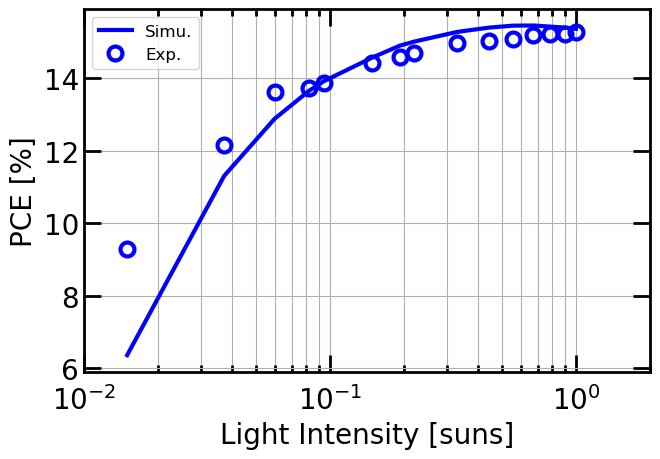

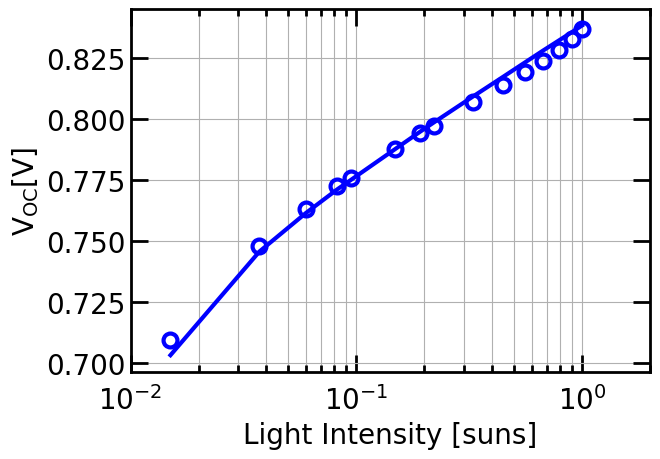

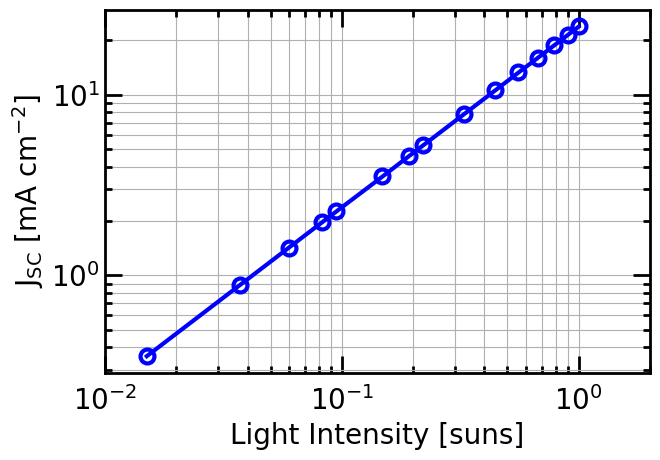

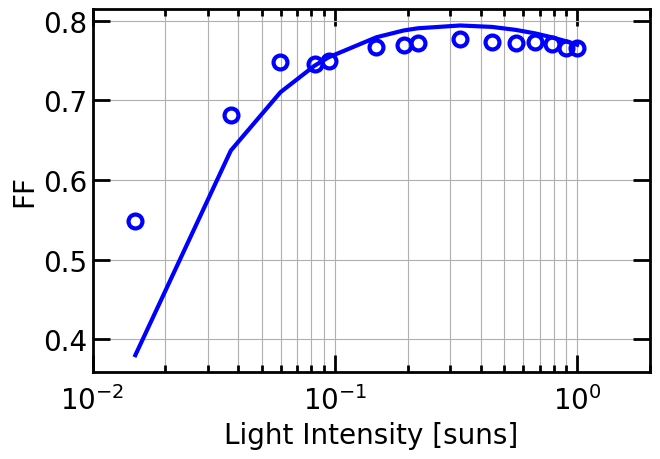

In [6]:
# Plot performance
plot_perf = True
if plot_perf:
    PlotJVPerf(Gfracs, scPars_files,y='PCE',Gfrac=Gfracs,plot_type=1,xlimits=[1e-2,2],ylimits=[],xlabel='Light Intensity [suns]',ylabel='PCE [%]',legend='Simu.',num_fig=5,mark='None',line_type = ['-'],norm_plot=False,fig_name=os.path.join(path2simu,'JV_perf.png'))

    PCE_exp,Voc_exp,Jsc_exp,FF_exp = [],[],[],[]
    for i,G in zip(ExpDataNames,Gfracs):
        JV = pd.read_csv(i,delim_whitespace=True)
        PCE_exp.append(get_PCE(JV['V'],JV['J'],G)/10)
        Voc_exp.append(get_Voc(JV['V'],JV['J']))
        Jsc_exp.append(-get_Jsc(JV['V'],JV['J']))
        FF_exp.append(get_FF(JV['V'],JV['J']))

    plt.plot(Gfracs,PCE_exp,'o',label='Exp.',markeredgecolor='b',markersize=10,markerfacecolor='None',markeredgewidth = 3)
    plt.legend(loc='best')

    PlotJVPerf(Gfracs, scPars_files,y='Voc',Gfrac=Gfracs,plot_type=1,xlimits=[1e-2,2],ylimits=[],xlabel='Light Intensity [suns]',ylabel='V$_{OC} [V]$',legend='',num_fig=6,mark='None',line_type = ['-'],norm_plot=False,fig_name=os.path.join(path2simu,'JV_perf.png'))
    plt.plot(Gfracs,Voc_exp,'o',label='Exp.',markeredgecolor='b',markersize=10,markerfacecolor='None',markeredgewidth = 3)

    PlotJVPerf(Gfracs, scPars_files,y='Jsc',Gfrac=Gfracs,plot_type=3,xlimits=[1e-2,2],ylimits=[],xlabel='Light Intensity [suns]',ylabel='J$_{SC}$ [mA cm$^{-2}$]',legend='',num_fig=7,mark='None',line_type = ['-'],norm_plot=True,fig_name=os.path.join(path2simu,'JV_perf.png'),norm_factor=10)
    plt.plot(Gfracs,np.asarray(Jsc_exp)/10,'o',label='Exp.',markeredgecolor='b',markersize=10,markerfacecolor='None',markeredgewidth = 3)

    PlotJVPerf(Gfracs, scPars_files,y='FF',Gfrac=Gfracs,plot_type=1,xlimits=[1e-2,2],ylimits=[],xlabel='Light Intensity [suns]',ylabel='FF',legend='',num_fig=8,mark='None',line_type = ['-'],norm_plot=False,fig_name=os.path.join(path2simu,'JV_perf.png'))
    plt.plot(Gfracs,FF_exp,'o',label='Exp.',markeredgecolor='b',markersize=10,markerfacecolor='None',markeredgewidth = 3)

In [7]:
# Clean output files from simulation folders
from SIMsalabim_utils.CleanFolder import *

Do_Cleaning = False # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPar',path2simu)
    clean_up_output('Str4Parallel',path2simu)